In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
df = pd.read_csv("datanew.csv")
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
y = df["Rainy"]

In [5]:
# some params
X3 = df.iloc[:, 3]
X4 = df.iloc[:, 4]
X5 = df.iloc[:, 5]
X6 = df.iloc[:, 6]
X9 = df.iloc[:, 9] # hg
X10 = df.iloc[:, 10]
X11 = df.iloc[:, 11]
X12 = df.iloc[:, 12]
X13 = df.iloc[:, 13] # soil
X14 = df.iloc[:, 14]
X15 = df.iloc[:, 15]
X18 = df.iloc[:, 18] # smd_pd
X = np.column_stack((X3,X4,X5,X6,X9,X10,X11,X12,X13,X14,X15,X18))

In [6]:
# all params
# X1 = df.iloc[:, 1]
# X2 = df.iloc[:, 2]
# X3 = df.iloc[:, 3]
# X4 = df.iloc[:, 4]
# X5 = df.iloc[:, 5]
# X6 = df.iloc[:, 6]
# X7 = df.iloc[:, 7]
# X8 = df.iloc[:, 8]
# X9 = df.iloc[:, 9]
# X10 = df.iloc[:, 10]
# X11 = df.iloc[:, 11]
# X12 = df.iloc[:, 12]
# X13 = df.iloc[:, 13]
# X14 = df.iloc[:, 14]
# X15 = df.iloc[:, 15]
# X16 = df.iloc[:, 16]
# X17 = df.iloc[:, 17]
# X18 = df.iloc[:, 18]
# X = np.column_stack((X1, X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18))

In [7]:
df.iloc[:,[3,4,5,6,9,10,12,13,14,15,18]].columns

Index(['igmin', 'gmin', 'cbl', 'wdsp', 'hg', 'sun', 'g_rad', 'soil', 'pe',
       'evap', 'smd_pd'],
      dtype='object')

In [8]:
dev_cutoff =int(len(y) * 7/10)
X_dev = X[:dev_cutoff]
y_dev = y[:dev_cutoff]
X_test = X[dev_cutoff:]
y_test = y[dev_cutoff:]

In [9]:
#数据集进行划分,使用70%的训练数据来训练，30%的数据用来测试，
def stacking(X,y):
    n_trees = 10
    n_folds = 5
    
    #第一层学习器
    clfs = [
#         RandomForestClassifier(n_estimators = n_trees, criterion = 'gini'),
#         ExtraTreesClassifier(n_estimators = n_trees * 2, criterion = 'gini'),
#         GradientBoostingClassifier(n_estimators = n_trees),
#         AdaBoostClassifier(random_state=2)
        KNeighborsClassifier(n_neighbors=69, weights='uniform'),
        RandomForestClassifier(n_estimators=92, random_state=90),
        SVC(kernel='linear', C=0.01, probability=True),
    ]
        
    # 数据交叉验证训练clf准备
    skf = list(StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=None).split(X_dev, y_dev))
    
    # 第二层的训练数据 blend_train
    blend_train = np.zeros((X_dev.shape[0], len(clfs))) # Number of training data x Number of classifiers
    blend_test = np.zeros((X_test.shape[0], len(clfs))) # Number of testing data x Number of classifiers
    
    print ('X_test.shape = %s' % (str(X_test.shape)))
    print ('blend_train.shape = %s' % (str(blend_train.shape)))
    print ('blend_test.shape = %s' % (str(blend_test.shape)))
    
    # 对每一个学习器进行训练，得到blend_train 和 blend_test
    for j, clf in enumerate(clfs):
        print ('Training classifier [%s]' % (j))
        blend_test_j = np.zeros((X_test.shape[0], n_folds)) # Number of testing data x Number of folds , we will take the mean of the predictions later
        roc_aou_fpr = []
        roc_aou_tpr = []
        for i, (train_index, test_index) in enumerate(skf):
            print ('Fold [%s]' % (i))
            
            # This is the training and validation set
            X_cv_train = X_dev[train_index]
            y_cv_train = y_dev[train_index]
            X_cv_test = X_dev[test_index]
            y_cv_test = y_dev[test_index]
            
            clf.fit(X_cv_train, y_cv_train)
            
            # This output will be the basis for our blended classifier to train against,
            # which is also the output of our classifiers
            blend_train[test_index, j] = clf.predict(X_cv_test)
            blend_test_j[:, i] = clf.predict(X_test)
            prediction = clf.predict(X_test)
            
        # Take the mean of the predictions of the cross validation set
        blend_test[:, j] = blend_test_j.mean(1)
    
     # 用 blend_train, y_dev 去训练第二层的学习器 LogisticRegression
    bclf = LogisticRegression()
    bclf.fit(blend_train, y_dev)
    
    # 基于训练的二级分类器，预测测试集 blend_test，并得到 score：
    y_test_predict = bclf.predict(blend_test)
    score = accuracy_score(y_test, y_test_predict)
    return score, y_test, y_test_predict

In [10]:
def plot_confusion_matrix(matrix):
    f = plt.figure(figsize=(3,3))
    ax = f.add_subplot()
    ax.matshow(matrix,cmap=plt.cm.Blues,alpha=0.3)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(x=j,y=i,s=matrix[i,j],va='center',ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')

In [11]:
def roc_auc_plot():
    f = plt.figure(figsize=(5,5))
    ax = f.add_subplot()
    roc_auc_score(y_test, y_test_predict)
    fpr, tpr, _ = roc_curve(y_test, y_test_predict)
    print(fpr)
    print(tpr)
    roc_auc = auc(fpr, tpr)
    ax.plot(
        fpr, tpr,
        color = "darkorange",
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Some extension of Receiver operating characteristic to multiclass")
    ax.legend(loc="lower right")

In [12]:
def appraise(y_test, y_test_predict):
    accuracy = accuracy_score(y_test, y_test_predict)
    recall = recall_score(y_test, y_test_predict, average='macro')
    f1 = f1_score(y_test, y_test_predict,average='weighted')
    confusion_mat = confusion_matrix(y_test, y_test_predict)
    
    print('Accuracy = %s' %(accuracy))
    print('Recall Score = %s' %(recall))
    print('F1 Score = %s' %(f1))
    
    plot_confusion_matrix(confusion_mat)
    roc_auc_plot()

Iteration [0]
X_test.shape = (2283, 12)
blend_train.shape = (5326, 3)
blend_test.shape = (2283, 3)
Training classifier [0]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
Training classifier [1]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
Training classifier [2]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
Best score = 0.8134034165571616
------------------------------
Accuracy = 0.8134034165571616
Recall Score = 0.7837467795362533
F1 Score = 0.8091317131622539
[0.         0.09684211 1.        ]
[0.         0.66433566 1.        ]


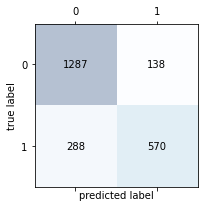

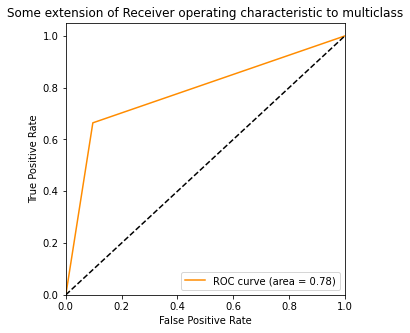

In [13]:
best_score = 0.0

# run many times to get a better result, it's not quite stable.
for i in range(1):
    print ('Iteration [%s]' % (i))
    score, y_test, y_test_predict = stacking(X, y)
    best_score = max(best_score, score)

print ('Best score = %s' % (best_score))
print ('------------------------------')

appraise(y_test, y_test_predict)
plt.show()

ROC_KNN: 0.8380133316975422
ROC_baseline: 0.5
ROC_Randomforest: 0.8811107021633338
ROC_SVM: 0.8811107021633338
ROC_Stacking: 0.79


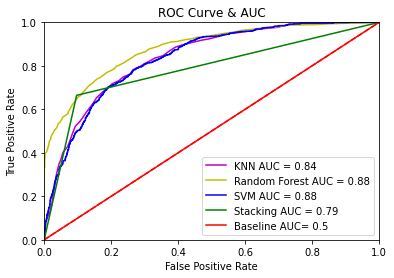

Score_KNN: 0.7687253613666228
Score_RandomForest: 0.8077091546211126
Score_SVM: 0.7634691195795007
Score_Stacking: 0.8151554971528691
Score_baseline: 0.6241787122207622


In [14]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent").fit(X_dev, y_dev)
ydummy = dummy.predict(X_test)

# model_R = Ridge(alpha=27.825594022071257).fit(X_dev, y_dev)
model_K = KNeighborsClassifier(n_neighbors=69, weights='uniform').fit(X_dev,y_dev)
model_F = RandomForestClassifier(n_estimators=92, random_state=90).fit(X_dev, y_dev)
model_S = SVC(kernel='linear', C=0.01, probability=True).fit(X_dev, y_dev)

# ################## ROC
fpr_F, tpr_F, _ = roc_curve(y_test, model_F.predict_proba(X_test)[:, 1])
# fpr_R, tpr_R, _ = roc_curve(y_test, model_R.predict_proba(X_test)[:, 1])
fpr_K, tpr_K, _ = roc_curve(y_test, model_K.predict_proba(X_test)[:, 1])
fpr_S, tpr_S, _ = roc_curve(y_test, model_S.predict_proba(X_test)[:, 1])
fpr_B, tpr_B, _ = roc_curve(y_test, dummy.predict_proba(X_test)[:, 1])
fpr_A, tpr_A, _ = roc_curve(y_test, y_test_predict)

# ################### AUC
roc_auc_K = auc(fpr_K, tpr_K)
print("ROC_KNN:",roc_auc_K)
roc_auc_B = auc(fpr_B,tpr_B)
print("ROC_baseline:",roc_auc_B)
roc_auc_F = auc(fpr_F,tpr_F)
print("ROC_Randomforest:",roc_auc_F)
roc_auc_S = auc(fpr_F,tpr_F)
print("ROC_SVM:",roc_auc_S)
roc_auc_A = 0.79
print("ROC_Stacking:",roc_auc_A)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_K, tpr_K, 'm', label ='KNN AUC = %0.2f' % roc_auc_K)
plt.plot(fpr_F, tpr_F, 'y', label ='Random Forest AUC = %0.2f' % roc_auc_F)
plt.plot(fpr_S, tpr_S, 'b', label ='SVM AUC = %0.2f' % roc_auc_S)
plt.plot(fpr_A, tpr_A, 'g', label ='Stacking AUC = %0.2f' % roc_auc_A)
plt.plot(fpr_B, tpr_B, 'r', label ='Baseline AUC= 0.5')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve & AUC')
plt.show()

##################### Score

# print("Score_Ridge:", model_R.score(X_test, y_test))
print("Score_KNN:",model_K.score(X_test,y_test))
print("Score_RandomForest:",model_F.score(X_test,y_test))
print("Score_SVM:",model_S.score(X_test,y_test))
print("Score_Stacking:",0.8151554971528691)
print("Score_baseline:",dummy.score(X_test,y_test))